In [1]:
from ase.build import bulk, make_supercell
import numpy as np

from HopDec.ASE import *
from HopDec.Input import *
from HopDec.Lammps import *
from HopDec.State import *

import HopDec.Redecorate as Redecorate
import HopDec.Dimer as Dimer
import HopDec.Minimize as Minimize
import HopDec.NEB as NEB
import HopDec.MD as MD

%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
# pull the parameters set in HopDec-config.xml and load in the input lammps file referenced in the parameters
params = getParams()
initialState = readStateLAMMPSData(params.inputFilename)

In [3]:
# mininize initialState in-place
lmp = LammpsInterface(params)
Minimize.main(initialState, lmp, params)

In [4]:
'''
The goal here is to find a 'hop'. 
That is, we have a known state and we want to find an new state.
We do this by running MD in segments of params.segmentLength at temperature: params.MDTemperature
after each segment, we check if any atom has moved > params.eventDisplacement
If any atom has then flag is set to 1 and the loop exits saving the new state as 'state'
'''

flag = 0
i = 0
while not flag:
    print(i)
    _, state, flag = MD.main(initialState, params)
    i +=1

0
1
2
3
4
5
[29/02/24, 13:55:32]: MD >> Transition detected in state: 


In [5]:
# write known states to file

initialState.writeState('0.dat')
state.writeState('1.dat')

In [6]:
# run a neb between known states and return a connection
connection = NEB.main(initialState, state, params, exportStructures = True, plotPathways = True) # run a NEB between these two states

In [7]:
# 'Connection' object is returned which contains 'Transitions'.
# A 'Connection' can contain many transitions
# A 'Transition' contains only one saddle and two minima

for trans in connection.transitions:
    print(trans.forwardBarrier)

0.6967
0.0244


In [8]:
# Given that we have found a valid Connection / Transition.
# We may want to run a redecoration campaign
# This one will take the States defined and conduct 10 NEBS (controlled in config file) 
# Then return a results object
params.nDecorations = 10
redecResults = Redecorate.main(connection.transitions[0].initialState, connection.transitions[0].finalState, params, pickle = True)


[29/02/24, 13:56:15]: Redecorate >> Starting NEB Redecoration Campaign
[29/02/24, 13:56:15]:   Redecorate >> rank: 0: Redecoration: 1
[29/02/24, 13:56:39]:   Redecorate >> rank: 0: Redecoration: 2
[29/02/24, 13:57:15]:   Redecorate >> rank: 0: Redecoration: 3
[29/02/24, 13:57:27]:   Redecorate >> rank: 0: Redecoration: 4
[29/02/24, 13:57:41]:   Redecorate >> rank: 0: Redecoration: 5
[29/02/24, 13:57:56]:   Redecorate >> rank: 0: Redecoration: 6
[29/02/24, 13:58:17]:   Redecorate >> rank: 0: Redecoration: 7
[29/02/24, 13:58:21]:   Redecorate >> rank: 0: Redecoration: 8
[29/02/24, 13:58:41]:   Redecorate >> rank: 0: Redecoration: 9
[29/02/24, 13:58:53]:   Redecorate >> rank: 0: Redecoration: 10


/Users/peterhatton/Desktop/git/hopdecorate/HopDec/Redecorate.py:139: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df,row], ignore_index=True)


In [9]:
# we can summarize all of the decorations (connections) with the method below.
# note that a decoration (connection) can contain many transitions.
redecResults.summarize()

[29/02/24, 13:59:18]: Redecorate >> Summary:
	Connection 1:
		Transition 1:
			transition.forwardBarrier = 1.6013
			transition.dE = -0.6887
	Connection 2:
		Transition 1:
			transition.forwardBarrier = 1.3525
			transition.dE = -1.3707
	Connection 3:
		Transition 1:
			transition.forwardBarrier = 0.1255
			transition.dE = -0.0942
	Connection 4:
		Transition 1:
			transition.forwardBarrier = 1.1214
			transition.dE = 1.111
	Connection 5:
		Transition 1:
			transition.forwardBarrier = 0.5092
			transition.dE = 0.3225
	Connection 6:
		Transition 1:
			transition.forwardBarrier = 0.8188
			transition.dE = -0.348
	Connection 7:
		Transition 1:
			transition.forwardBarrier = 0.2358
			transition.dE = -0.9137
	Connection 8:
		Transition 1:
			transition.forwardBarrier = 0.0642
			transition.dE = -0.032
	Connection 9:
		Transition 1:
			transition.forwardBarrier = 1.2141
			transition.dE = -0.4447


(array([2., 1., 1., 0., 1., 0., 1., 1., 1., 1.]),
 array([0.0642 , 0.21791, 0.37162, 0.52533, 0.67904, 0.83275, 0.98646,
        1.14017, 1.29388, 1.44759, 1.6013 ]),
 <BarContainer object of 10 artists>)

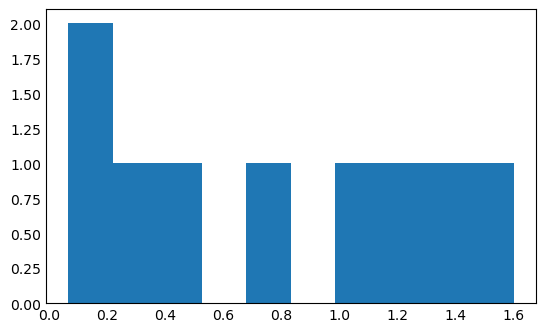

In [14]:
# we can now plot the distributions of barriers we found

data = [ conn.transitions[0].forwardBarrier for conn in redecResults.connections ]
fig, axs = plt.subplots(1,1, figsize = (5,3))
axs.hist(data)

In [11]:
'''
The redecoration process produces a .pickle file which is a pickle of a pandas df containing information about the barriers associated with a given decoration.
we can inspect that pickle for further analysis.

'''
import pickle
import pandas as pd

In [15]:
# since we know the pickle is a pandas dataframe, we can use the inbuilt method in pandas to read it to memory
d = pd.read_pickle('36ab0b93d0440220b62f1d373e8a1352.pickle')
d

,initialState,finalState,KRA,dE,initialState_Energy,finalState_Energy
0,"(Atom('Al', [7.3030572786620525, 1.03148405076...","(Atom('Al', [7.288274399478207, 1.045938912676...",1.9456,-0.6887,-5893.814893,-5894.503593
1,"(Atom('Mg', [7.333606154757452, 1.065481223780...","(Atom('Mg', [7.3319054940330854, 1.06656409577...",2.0378,-1.3707,-5896.846986,-5898.217642
2,"(Atom('Al', [7.305706102942462, 1.062913824308...","(Atom('Al', [7.311842170147592, 1.062337598812...",0.1726,-0.0942,-5898.157495,-5898.251698
3,"(Atom('Mg', [7.333686700378506, 1.070357736024...","(Atom('Mg', [7.3363141604076905, 1.07503726434...",0.5659,1.1110,-5898.962678,-5897.851652
4,"(Atom('Al', [7.334597081113589, 1.061731500290...","(Atom('Al', [7.335515806064644, 1.065219931369...",0.3480,0.3225,-5896.681897,-5896.359380
5,"(Atom('Mg', [7.304384890486121, 1.065835985687...","(Atom('Mg', [7.30261221228179, 1.1024157741348...",0.9928,-0.3480,-5895.137343,-5895.485370
6,"(Atom('Al', [7.3065371919386415, 1.03102674665...","(Atom('Al', [7.302422158913106, 1.042666144682...",0.6926,-0.9137,-5893.072280,-5893.985986
7,"(Atom('Al', [7.307959408210617, 1.057011726001...","(Atom('Al', [7.318017877216371, 1.058523044568...",0.0802,-0.0320,-5895.812477,-5895.844434
8,"(Atom('Mg', [7.277936790964701, 1.106524373110...","(Atom('Mg', [7.271594698820002, 1.137330950783...",1.4364,-0.4447,-5897.281999,-5897.726738


In [16]:
# we can then write the decorated structures to file.
# or we could loop over the rows of the data frame and write each structure to file

ase = ASE(params)
i = ase.toState(d['initialState'][0])
f = ase.toState(d['finalState'][0])

i.writeState('0.dat')
f.writeState('1.dat')